# Summary

## Implementation of The 10-armed Testbed using *Upper Confidence Bound* action selection discussed in section 2.7 of Sutton & Barto book [1]
- Shows the performance on the 10-armed bandit testbed in a stationary problem, using incremental sample-average for Q update for two different action selection methods:
    - epsilon-Greedy action selection with epsilon=0.1    
    - Upper Confidence Bound (UCB) action selection with c=2

[1] Sutton, R. S. & Barto, A. G. (2018), Reinforcement Learning: An Introduction, The MIT Press.

In [1]:
#Import statements
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [2]:
def plot_results(returns):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
    # Plotting average reward per time step    
    for k, v in returns.items():
        y = np.mean(v['R'], axis=0)
        x = np.arange(0, len(y))
        ax[0,0].plot(x, y, label=k)

    ax[0,0].set(title='Rewards',
           ylabel='Average Reward',
           xlabel='')
    ax[0,0].legend(loc='lower right') 

    # Plotting % optimal actions taken when in time-step t
    for k, v in returns.items():
        y = np.sum(v['opt_A'], axis=0)/total_runs
        x = np.arange(0, len(y))
        ax[0,1].plot(x, y, label=k)

    ax[0,1].set(title='Actions',
           ylabel='% Optimal Actions',
           xlabel='')    
    ax[0,1].legend(loc='lower right') 
    
    # Plotting average cumulative reward per time step    
    for k, v in returns.items():
        y = np.mean(np.cumsum(v['R'], axis=1), axis=0)
        x = np.arange(0, len(y))
        ax[1,0].plot(x, y, label=k)

    ax[1,0].set(title='',
           ylabel='Average Reward - Cumulative',
           xlabel='Time')
    ax[1,0].legend(loc='lower right') 

    # Plotting average % optimal actions
    for k, v in returns.items():
        y = np.mean(np.cumsum(v['opt_A'], axis=1)/T, axis=0)
        x = np.arange(0, len(y))
        ax[1,1].plot(x, y, label=k)

    ax[1,1].set(title='',
           ylabel='Average % Optimal Actions - Cumulative',
           xlabel='Time')    
    ax[1,1].legend(loc='lower right') 
    
    #fig.tight_layout()
    plt.show()

In [3]:
def take_action(epsilon, Q, A):
    '''
    Epsilon-greedy action selection.
    
    Parameters
    ----------
    epsilon : float
        Epsilon value for epsilon-greedy action selection method.
    Q : array_like
        Values of actions
    A : array_like
        Actions set.        
        
    Returns
    -------
    action : int
        Action taken.
    best_action : int
        Greedy action, i.e., argmax Q(a).
    
    '''
    nA = len(A)
    probs = np.ones(nA)*epsilon/nA
    best_a = np.argmax(Q) # Ideally should break ties arbitrarialy. Numpy.argmax always returns the first ocurrence in array in case of ties.
    probs[best_a] = 1 - epsilon + epsilon/nA        
    action = np.random.choice(A, p=probs) # Action selection (action taken)            
    return action, best_a

def take_action_ucb(Q, c, t, N):
    '''
    UBC action selection.
    
    Parameters
    ----------
    Q : array_like
        Values of actions
    c : float
        Controls the degree of exploration. Obs: c > 0.
    t : int
        Time-step.
    N : array_like
        How many times each action was selected
        
    Returns
    -------
    int
        Action taken.
    
    '''
    # If N(a) == 0, a is maximizing action
    zeros = []
    i = 0
    for n in N:
        if n == 0:
            zeros.append(i)
        i += 1
    
    if len(zeros) > 0:
        action = np.random.choice(zeros)        
    else:
        Q_ucb = Q + c*np.sqrt(np.log(t)/N)
        action = np.argmax(Q_ucb)
        
    return action
            
    

def get_bandit_reward(action_true_value, rewards_var):
    '''
    Gets the reward (as selected from a normal distribution with mean q*(At) and variance rewards_var. 
    
    Parameters
    ----------
    action_true_value : float
        Mean of the normal distribution.
    rewards_var : float
        Variance of the normal distribution.
        
    Returns
    -------
    float
        Reward sampled.    
    
    '''    
    return np.random.default_rng().normal(action_true_value, np.sqrt(rewards_var)) 

def q_update(Qn, r, alpha):
    '''
    Updates the estimated value of an action. 
    Generalized form: new_estimate <- old_estimate + step_size*[target - old_estimate]
    
    Parameters
    ----------
    Qn : float
        Estimated value of an action a after it has been selected n-1 times.    
    r : float
        Reward received in current time step.
    alpha : float
        Step-size parameter. 0 <= alpha < 1
        
    Returns
    -------
    float
        Estimated value of an action a after its n-th selection.
    
    '''    
    return Qn + alpha*(r - Qn)

In [4]:
def run_episode_egreedy_stat(action_true_values, rewards_var, T, epsilon, Qini):
    '''
    Runs an episode (a "run") where a learning method is applied to the k-armed bandit problem.
    Uses epsilon-greedy action selection.
    
    Parameters
    ----------
    action_true_values : array_like
        True values of the actions based on a specific distribution. Actions are choosen according to this distribution.
    rewards_var : float
        Variance of the reward distribution for each action.
    T : int
        Length of the episode (in time steps)
    epsilon : float
        Epsilon value for epsilon-greedy action selection method.
    Qini : array_like
        Initial values for actions values.
        
    Returns
    -------
    Q : array_like
        Values of actions
    R : array_like
        Rewards obtained in each time step.
    opt_A : array_like
        1 if action taken in time step t was optimal (best action), 0 otherwise.       
    
    '''
    # Initial values    
    t = 0 # Time step    
    nA = len(action_true_values) # Number of arms (actions)    
    R = np.zeros(T) # Rewards over time
    Q = Qini.copy() # Action-Value estimated for each action
    A = np.arange(0, nA) # Action set
    N = np.zeros_like(A) # How many times each action was selected
    opt_A = np.zeros(T) # 1 if action taken in time step t was optimal, 0 otherwise
    optimal_action = np.argmax(action_true_values) # Optimal action for this instance.
    
    # A run (T time steps)
    while t < T:
        # Acting (Obtains the action corresponding to epsilon-greedy policy)
        action, best_a = take_action(epsilon, Q, A)
        N[action] += 1        
        
        if action == optimal_action:
            opt_A[t] += 1        
        
        # Getting the reward (as selected from a normal distribution with mean q*(At) and variance rewards_var. 
        R[t] = get_bandit_reward(action_true_values[action], rewards_var)

        # Updating values of actions (Q) using contant alpha
        alpha = 1/N[action]
        Q[action] = q_update(Q[action], R[t], alpha)

        # Ending current time step
        t += 1

    return Q, R, opt_A

In [5]:
def run_episode_ucb_stat(action_true_values, rewards_var, T, c, Qini):
    '''
    Runs an episode (a "run") where a learning method is applied to the k-armed bandit problem.
    Uses upper-confidence-bound (ucb) action selection.
    
    Parameters
    ----------
    action_true_values : array_like
        True values of the actions based on a specific distribution. Actions are choosen according to this distribution.
    rewards_var : float
        Variance of the reward distribution for each action.
    T : int
        Length of the episode (in time steps)
    c : float
        Controls the degree of exploration. Obs.: c > 0
    Qini : array_like
        Initial values for actions values.
        
    Returns
    -------
    Q : array_like
        Values of actions
    R : array_like
        Rewards obtained in each time step.
    opt_A : array_like
        1 if action taken in time step t was optimal (best action), 0 otherwise.       
    
    '''
    # Initial values    
    t = 0 # Time step    
    nA = len(action_true_values) # Number of arms (actions)    
    R = np.zeros(T) # Rewards over time
    Q = Qini.copy() # Action-Value estimated for each action
    Q_ucb = Q.copy() # UCB for action-value
    A = np.arange(0, nA) # Action set
    N = np.zeros_like(A) # How many times each action was selected
    opt_A = np.zeros(T) # 1 if action taken in time step t was optimal, 0 otherwise
    optimal_action = np.argmax(action_true_values) # Optimal action for this instance.
    
    # A run (T time steps)
    while t < T:
        # Acting (Obtains the action using upper-confidence-bound selection)        
        action = take_action_ucb(Q, c, t+1, N)
        N[action] += 1        
        
        if action == optimal_action:
            opt_A[t] += 1        
        
        # Getting the reward (as selected from a normal distribution with mean q*(At) and variance rewards_var. 
        R[t] = get_bandit_reward(action_true_values[action], rewards_var)

        # Updating values of actions (Q) using contant alpha
        alpha = 1/N[action]
        Q[action] = q_update(Q[action], R[t], alpha)

        # Ending current time step
        t += 1

    return Q, R, opt_A

In [6]:
def simulate_egreedy_stat(k, total_runs, rewards_var, T, epsilon, Qini):
    '''
    Simulate several instances of k-armed bandit problem
    
    Parameters
    ----------    
    k : int
        Number of actions, i.e., how many arms the bandit has.
    total_runs : int
        Number of randomly generated k-armed bandit problems. How many times the problem will be simulated.
    rewards_var : float
        Variance of the reward distribution for each action.    
    T : int
        Duration of a single problem (total of time steps).
    epsilon : float
        Epsilon value for epsilon-greedy action selection method. A 0 value means greedy.
    Qini : array_like
        Initial values for actions values.
    
        
    Returns
    -------
    Q : array_like 
        Final values estimated for every action in every run.
    R : array_like
        Matrix with returns per time for every run.
    opt_A : array_like
        For every run and every time step informs if the optimal action was the action taken. 
        Gives 1 if action taken in time step t was optimal, 0 otherwise
    
    '''
    Q = np.zeros((total_runs,k))
    R = np.zeros((total_runs,T))
    opt_A = np.zeros((total_runs,T))
    # Running total_runs instances of the problem
    for i in np.arange(0, total_runs):  
        # Monitor progress
        if (i+1) % 10 == 0:
            print('\rRuns {}/{}.'.format(i+1, total_runs), end='', flush=True)            
        
        # Creating reward distribution for actions
        # Actions true-values, i.e., q*(At), from a normal distribution with mean=0 and variance=1. 
        action_true_values = np.random.default_rng().normal(0, 1, k)

        # Running an episode of time length T        
        Q[i,:], R[i,:], opt_A[i,:] = run_episode_egreedy_stat(action_true_values, rewards_var, T, epsilon, Qini)

    return Q, R, opt_A

In [7]:
def simulate_ucb_stat(k, total_runs, rewards_var, T, c, Qini):
    '''
    Simulate several instances of k-armed bandit problem
    
    Parameters
    ----------    
    k : int
        Number of actions, i.e., how many arms the bandit has.
    total_runs : int
        Number of randomly generated k-armed bandit problems. How many times the problem will be simulated.
    rewards_var : float
        Variance of the reward distribution for each action.    
    T : int
        Duration of a single problem (total of time steps).
    c : float
        Controls the degree of exploration. Obs.: c > 0
    Qini : array_like
        Initial values for actions values.
    
        
    Returns
    -------
    Q : array_like 
        Final values estimated for every action in every run.
    R : array_like
        Matrix with returns per time for every run.
    opt_A : array_like
        For every run and every time step informs if the optimal action was the action taken. 
        Gives 1 if action taken in time step t was optimal, 0 otherwise
    
    '''
    Q = np.zeros((total_runs,k))
    R = np.zeros((total_runs,T))
    opt_A = np.zeros((total_runs,T))
    # Running total_runs instances of the problem
    for i in np.arange(0, total_runs):  
        # Monitor progress
        if (i+1) % 10 == 0:
            print('\rRuns {}/{}.'.format(i+1, total_runs), end='', flush=True)            
        
        # Creating reward distribution for actions
        # Actions true-values, i.e., q*(At), from a normal distribution with mean=0 and variance=1. 
        action_true_values = np.random.default_rng().normal(0, 1, k)

        # Running an episode of time length T        
        Q[i,:], R[i,:], opt_A[i,:] = run_episode_ucb_stat(action_true_values, rewards_var, T, c, Qini)

    return Q, R, opt_A

#General Info:
k = 10, total_runs = 2000, T = 1000
rewards_var = 1

Running e-greedy...
Runs 2000/2000.finished in 0:03:54.600826
Running UCB...
Runs 2000/2000.finished in 0:02:48.567773


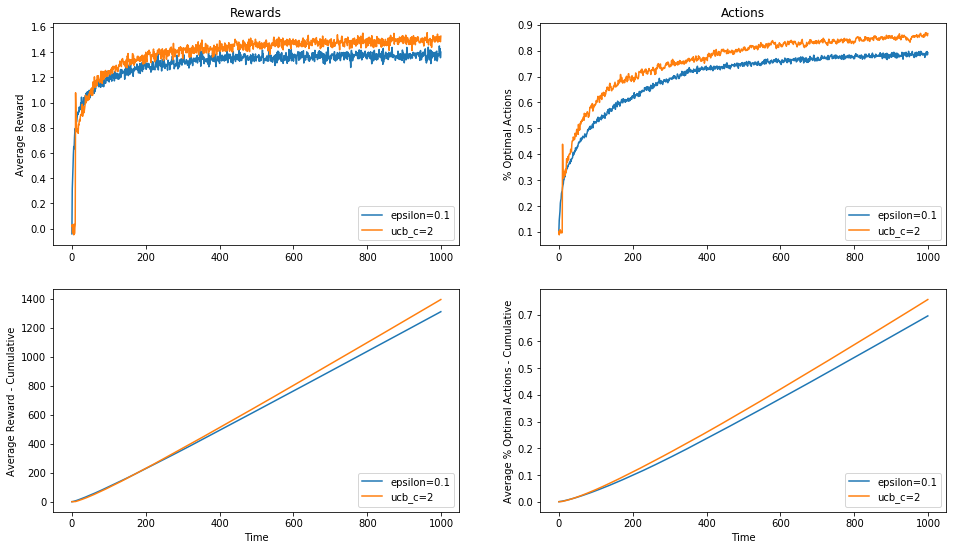

In [8]:
# Problem setup
k = 10 # Number of actions, i.e., how many arms the bandit has.
total_runs  = 2000 # Number of randomly generated k-armed bandit problems .
T = 1000 # Total of time steps per instance.

# Variance parameter for rewards sampling.
rewards_var = 1

# Returns for all simulations
returns = {} 

# Printing info
print('#General Info:')
print('k = {}, total_runs = {}, T = {}'.format(k, total_runs, T))
print('rewards_var = {}\n'.format(rewards_var))

## Epsilon-greedy action selection method.
epsilon = 0.1
# Initial values for Q
Qini = np.zeros(k)

start = time.time()
print('Running e-greedy...'.format(epsilon))
t_Q, t_R, t_opt_A = simulate_egreedy_stat(k, total_runs, rewards_var, T, epsilon, Qini)
returns['epsilon='+str(epsilon)] = {'Q':t_Q, 'R':t_R, 'opt_A':t_opt_A}
print('finished in {}'.format(timedelta(seconds=time.time() - start)), flush=True)


## Upper-confidence-bound action selection method.
c = 2
# Initial values for Q
Qini = np.zeros(k)

start = time.time()
print('Running UCB...'.format(c))
t_Q, t_R, t_opt_A = simulate_ucb_stat(k, total_runs, rewards_var, T, c, Qini)
returns['ucb_c='+str(c)] = {'Q':t_Q, 'R':t_R, 'opt_A':t_opt_A}
print('finished in {}'.format(timedelta(seconds=time.time() - start)), flush=True)

# Visual
plot_results(returns)

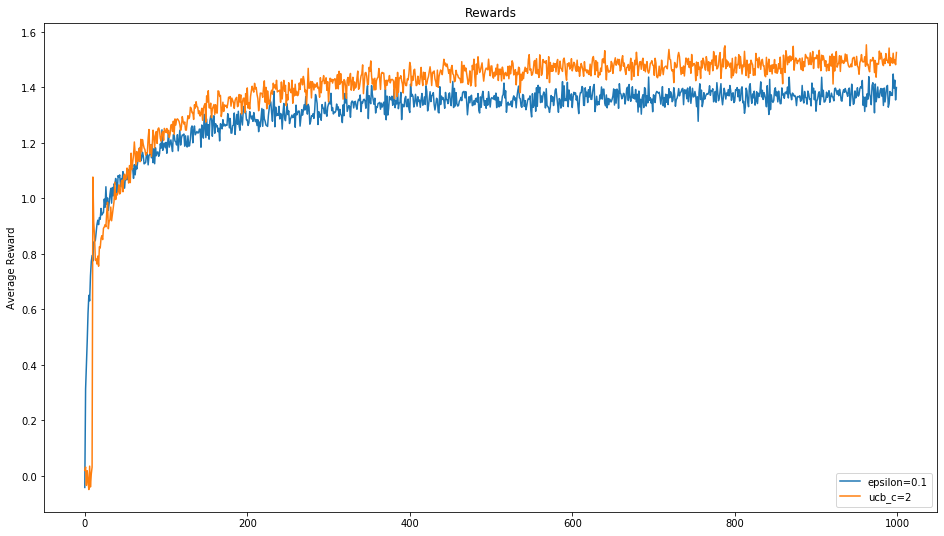

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
# Plotting average reward per time step    
for k, v in returns.items():
    y = np.mean(v['R'], axis=0)
    x = np.arange(0, len(y))
    ax.plot(x, y, label=k)

ax.set(title='Rewards',
       ylabel='Average Reward',
       xlabel='')
ax.legend(loc='lower right') 
plt.show()